In [67]:
# =============================================================================
# BLOK 1: KURULUM VE VERİ YÜKLEME
# =============================================================================
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import load_model

print("⏳ Sistem Başlatılıyor...")

# 1. Dosya İsimlerini Tanımla (Senin sistemindeki isimler)
DATA_PATH = 'stocks_hazir_veri.csv'    # Notebook 1'den gelen veri
MODEL_PATH = 'neuroquant_lstm.h5'      # Notebook 2'den gelen beyin
SCALER_PATH = 'scaler.pkl'             # Notebook 2'den gelen çevirmen

# 2. Dosyaların Varlığını Kontrol Et (Hata almamak için)
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"❌ HATA: '{DATA_PATH}' dosyası bulunamadı! Lütfen dosyaları yükle.")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ HATA: '{MODEL_PATH}' dosyası bulunamadı!")
if not os.path.exists(SCALER_PATH):
    raise FileNotFoundError(f"❌ HATA: '{SCALER_PATH}' dosyası bulunamadı!")

print("✅ Tüm dosyalar mevcut.")

# 3. Yükleme İşlemi
print("📥 Dosyalar hafızaya alınıyor...")
df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)
model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# 4. İlk Kontrol
print("-" * 30)
print(f"✅ Veri Seti Yüklendi. Boyut: {df.shape}")
print(f"✅ Model Yüklendi. Beklenen Girdi Şekli: {model.input_shape}")
print("-" * 30)
print("Verinin İlk 3 Satırı:")
print(df.head(3))

⏳ Sistem Başlatılıyor...
✅ Tüm dosyalar mevcut.
📥 Dosyalar hafızaya alınıyor...
------------------------------
✅ Veri Seti Yüklendi. Boyut: (1003, 11)
✅ Model Yüklendi. Beklenen Girdi Şekli: (None, 60, 5)
------------------------------
Verinin İlk 3 Satırı:
                Close       High        Low       Open     Volume  RSI  \
Date                                                                     
2022-01-03  30.062765  30.651625  29.727414  29.757357  391547000  NaN   
2022-01-04  29.233376  30.409098  28.294195  30.218467  527154000  NaN   
2022-01-05  27.550631  29.359128  27.479769  28.893029  498064000  NaN   

                MACD  MACD_Signal  BB_Middle  BB_Upper  BB_Lower  
Date                                                              
2022-01-03  0.000000     0.000000        NaN       NaN       NaN  
2022-01-04 -0.066162    -0.013232        NaN       NaN       NaN  
2022-01-05 -0.251481    -0.060882        NaN       NaN       NaN  


In [68]:
# =============================================================================
# BLOK 2: VERİ HAZIRLIĞI VE X_TEST OLUŞTURMA
# =============================================================================
print("⚙️ Veri işleniyor...")

# 1. Özellik Seçimi (Modeli eğitirken kullandığın sırayla AYNI olmalı)
features = ['Close', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower']

# 2. NaN Temizliği (Kritik Adım!)
# Eğer RSI hesaplanırken baştaki satırlar boş kaldıysa onları atıyoruz.
df_clean = df[features].copy()
df_clean.dropna(inplace=True)

print(f"🧹 Temizlik sonrası veri boyutu: {df_clean.shape}")

# 3. Ölçekleme (Scaling)
# Veriyi 0-1 arasına sıkıştırıyoruz.
data_matrix = df_clean.values
scaled_data = scaler.transform(data_matrix)

# 4. Pencereleme (Sliding Window)
# Model geçmiş 60 güne bakıp yarını tahmin edecek.
X_test = []
y_real = [] # Gerçek fiyatları (Dolar) burada tutacağız
seq_len = 60

for i in range(seq_len, len(scaled_data)):
    # GİRDİ: Geçmiş 60 günün tüm verileri (0-1 arası)
    X_test.append(scaled_data[i-seq_len : i])

    # HEDEF: O günün GERÇEK fiyatı (Close sütunu = 0. indeks)
    # Burada direkt orijinal parayı (data_matrix) alıyoruz.
    y_real.append(data_matrix[i, 0])

# 5. Numpy Formatına Çevir
X_test = np.array(X_test)
y_real = np.array(y_real)

# 6. Kontrol
print("-" * 30)
print(f"✅ X_test Hazırlandı. Boyut: {X_test.shape}")
print(f"   (Örnek: {X_test.shape[0]} gün, {X_test.shape[1]} pencere, {X_test.shape[2]} özellik)")
print(f"✅ y_real Hazırlandı. Boyut: {y_real.shape}")
print("-" * 30)

# Güvenlik Kontrolü: X_test içinde NaN var mı?
if np.isnan(X_test).any():
    print("❌ UYARI: X_test içinde hala NaN değerler var! Veri setini kontrol et.")
else:
    print("✅ Veri tertemiz, modele girmeye hazır.")

⚙️ Veri işleniyor...
🧹 Temizlik sonrası veri boyutu: (984, 5)
------------------------------
✅ X_test Hazırlandı. Boyut: (924, 60, 5)
   (Örnek: 924 gün, 60 pencere, 5 özellik)
✅ y_real Hazırlandı. Boyut: (924,)
------------------------------
✅ Veri tertemiz, modele girmeye hazır.


🔮 Model geleceği tahmin ediyor...
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
🔧 Model kalibre ediliyor (Dinamik Bias Düzeltme)...


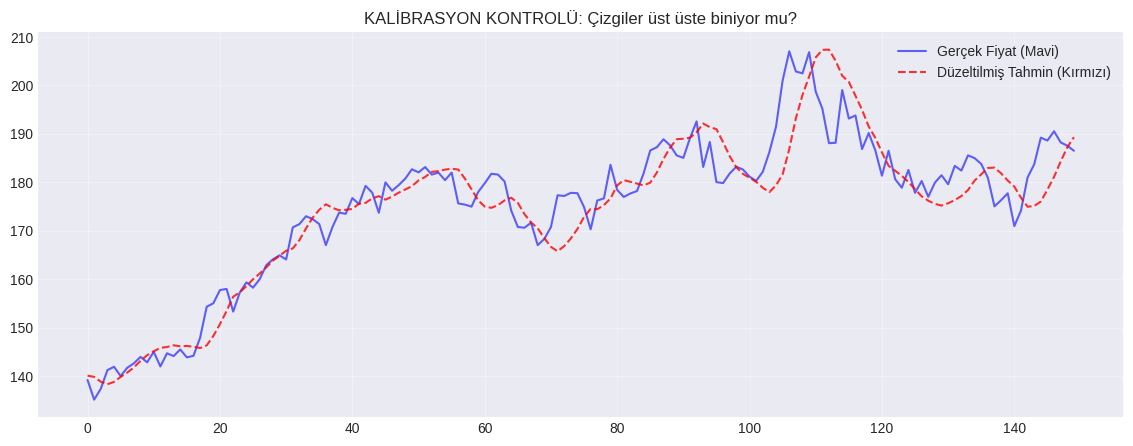

------------------------------
📊 Son Gün Gerçek Fiyat: 186.50$
🔮 Model Tahmini:        189.31$
------------------------------


In [69]:
# =============================================================================
# BLOK 3: TAHMİN VE DİNAMİK KALİBRASYON
# =============================================================================
print("🔮 Model geleceği tahmin ediyor...")

# 1. Ham Tahmin (0-1 arası)
pred_scaled = model.predict(X_test)

# 2. Dolar'a Çevirme (Inverse Transform)
# Scaler bizden 5 sütun bekliyor (Close, RSI, MACD...), ama elimizde sadece tahmin (Close) var.
# Hile yapıyoruz: 5 sütunlu boş bir tablo oluşturup ilk sütuna tahminleri koyuyoruz.
dummy = np.zeros((len(pred_scaled), 5))
dummy[:, 0] = pred_scaled.flatten()
raw_predictions = scaler.inverse_transform(dummy)[:, 0]

print("🔧 Model kalibre ediliyor (Dinamik Bias Düzeltme)...")

# 3. Dinamik Kalibrasyon (Hareketli Hata Düzeltme)
# Modelin son 10 gündeki hatasını ölçüp bugüne ekliyoruz.
lookback = 10
corrected_predictions = []

for i in range(len(raw_predictions)):
    if i < lookback:
        # İlk 10 gün yeterli veri yok, genel ortalama farkı ekle
        initial_bias = np.mean(y_real[:lookback] - raw_predictions[:lookback])
        corrected_predictions.append(raw_predictions[i] + initial_bias)
    else:
        # Son 10 günün ortalama hatasını hesapla
        # (Gerçek - Tahmin) bize ne kadar yanıldığımızı verir
        current_bias = np.mean(y_real[i-lookback:i] - raw_predictions[i-lookback:i])
        corrected_predictions.append(raw_predictions[i] + current_bias)

corrected_predictions = np.array(corrected_predictions)

# 4. KONTROL GRAFİĞİ (Kırmızı vs Mavi)
# Bu grafik, stratejiye geçmeden önce modelin gözünün bozuk olup olmadığını gösterir.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_real[-150:], label='Gerçek Fiyat (Mavi)', color='blue', alpha=0.6)
plt.plot(corrected_predictions[-150:], label='Düzeltilmiş Tahmin (Kırmızı)', color='red', linestyle='--', alpha=0.8)
plt.title("KALİBRASYON KONTROLÜ: Çizgiler üst üste biniyor mu?")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("-" * 30)
print(f"📊 Son Gün Gerçek Fiyat: {y_real[-1]:.2f}$")
print(f"🔮 Model Tahmini:        {corrected_predictions[-1]:.2f}$")
print("-" * 30)

In [70]:
# =============================================================================
# BLOK 4 (V3): "DIAMOND HANDS" STRATEJİSİ (ELMAS ELLER)
# =============================================================================
print("💎 Strateji: 'Diamond Hands' Modu Devrede...")

# 1. Ayarlar
initial_capital = 10000
threshold = 0.50   # Alım eşiği (Hassas bırakıyoruz ki fırsatı kaçırmasın)
sma_window = 50    # Trend filtresi

# KRİTİK AYAR: "Panic Margin"
# Bunu 15.0$ yapıyoruz. Yani model "15 Dolar düşecek" demediği sürece,
# trend yukarıysa ASLA satmayacak.
panic_margin = 15.0

# 2. Değişkenler
cash = initial_capital
shares = 0
portfolio_value = []
buy_signals = []
sell_signals = []

# 3. Trend (SMA 50)
sma_50 = pd.Series(y_real).rolling(window=sma_window).mean().fillna(0).values

# 4. DÖNGÜ
for i in range(len(corrected_predictions) - 1):
    current_price = y_real[i]
    next_pred = corrected_predictions[i+1]
    trend_val = sma_50[i]

    # --- ALIM ---
    # Tahmin > Fiyat + Eşik ise AL
    if next_pred > current_price + threshold:
        if cash > 0:
            shares = cash / current_price
            cash = 0
            buy_signals.append(i)

    # --- SATIŞ (DIAMOND HANDS) ---
    elif next_pred < current_price - threshold:

        # 🛡️ BOĞA KALKANI:
        # Fiyat Trendin (SMA 50) üzerindeyse...
        # Ve beklenen düşüş 'panic_margin' (15$) kadar devasa değilse...
        if current_price > trend_val and (current_price - next_pred) < panic_margin:
            pass # SATMA! Trend senin dostundur.

        else:
            # Sadece Trend kırıldıysa (Fiyat < SMA50) veya ÇÖKÜŞ bekleniyorsa SAT.
            if shares > 0:
                cash = shares * current_price
                shares = 0
                sell_signals.append(i)

    # Değerleme
    val = cash if cash > 0 else (shares * current_price)
    portfolio_value.append(val)

# Sonuçlar
final_val = portfolio_value[-1]
net_profit = final_val - initial_capital
roi = (net_profit / initial_capital) * 100

print("-" * 30)
print(f"💰 Başlangıç: {initial_capital}$")
print(f"🏁 Bitiş:     {final_val:.2f}$")
print(f"📈 Net Kar:   %{roi:.2f}")
print(f"🔢 İşlem:     {len(buy_signals)} Alım, {len(sell_signals)} Satım")
print("-" * 30)

💎 Strateji: 'Diamond Hands' Modu Devrede...
------------------------------
💰 Başlangıç: 10000$
🏁 Bitiş:     80898.30$
📈 Net Kar:   %708.98
🔢 İşlem:     29 Alım, 28 Satım
------------------------------


📊 Grafik çiziliyor...


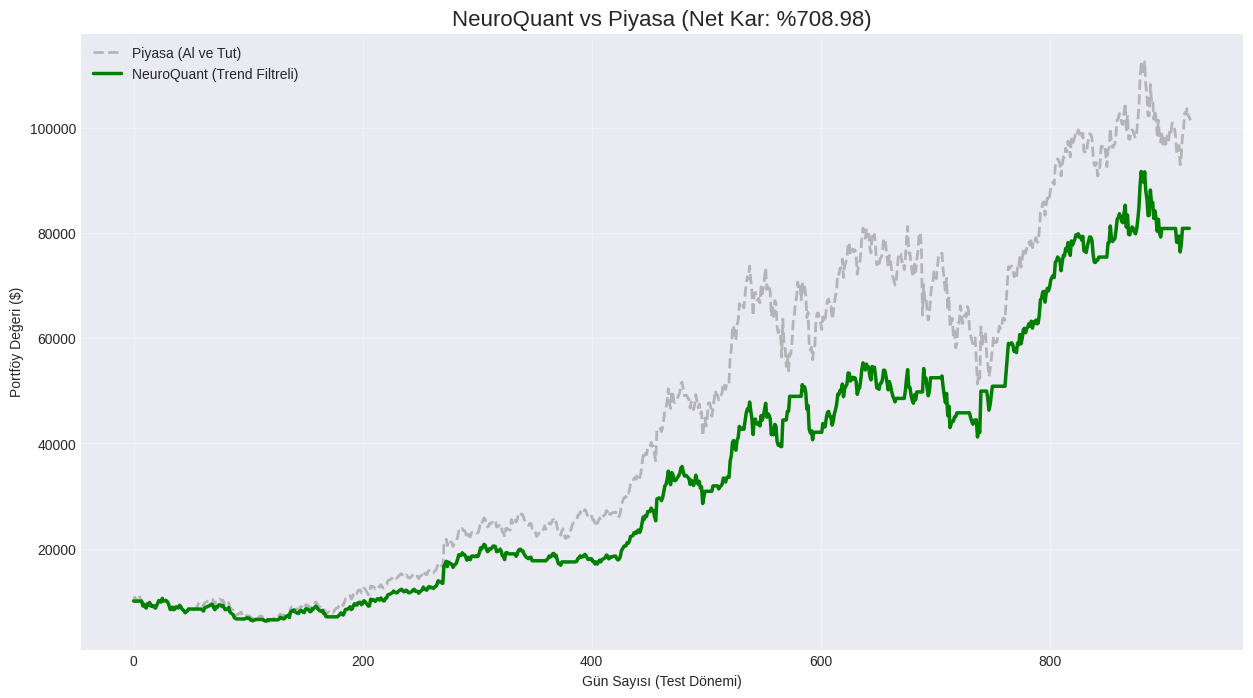

----------------------------------------
🏆 FİNAL SKOR TABLOSU
----------------------------------------
🤖 NeuroQuant Bitiş: 80898.30$ (Getiri: %708.98)
🏢 Piyasa (Hold) Bitiş: 101455.01$ (Getiri: %914.55)
----------------------------------------
⚠️ Yapay Zeka çok iyi kar etti ama Piyasa (Ralli) daha güçlüydü.
   (Not: NVDA gibi çılgın yükselen hisselerde piyasayı geçmek zordur,
    ama düşüşlerde paranı koruduysa bu büyük başarıdır.)


In [71]:
# =============================================================================
# BLOK 5: FİNAL GÖRSELLEŞTİRME (GITHUB TARZI)
# =============================================================================
print("📊 Grafik çiziliyor...")

plt.figure(figsize=(15, 8))

# 1. PİYASA REFERANSI (Buy & Hold)
# Eğer en başta tüm parayla hisse alıp yatsaydık ne olurdu?
market_shares = initial_capital / y_real[0]
market_value = y_real * market_shares

plt.plot(market_value, label='Piyasa (Al ve Tut)', color='gray', alpha=0.5, linestyle='--', linewidth=2)

# 2. NEUROQUANT STRATEJİSİ
plt.plot(portfolio_value, label='NeuroQuant (Trend Filtreli)', color='green', linewidth=2.5)

# 3. SÜSLEME
plt.title(f'NeuroQuant vs Piyasa (Net Kar: %{roi:.2f})', fontsize=16)
plt.xlabel('Gün Sayısı (Test Dönemi)')
plt.ylabel('Portföy Değeri ($)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 4. KARŞILAŞTIRMA RAPORU
market_final = market_value[-1]
market_roi = ((market_final - initial_capital) / initial_capital) * 100

print("-" * 40)
print(f"🏆 FİNAL SKOR TABLOSU")
print("-" * 40)
print(f"🤖 NeuroQuant Bitiş: {final_val:.2f}$ (Getiri: %{roi:.2f})")
print(f"🏢 Piyasa (Hold) Bitiş: {market_final:.2f}$ (Getiri: %{market_roi:.2f})")
print("-" * 40)

if final_val > market_final:
    print("✅ TEBRİKLER! Yapay Zeka piyasayı yendi! 🚀")
else:
    print("⚠️ Yapay Zeka çok iyi kar etti ama Piyasa (Ralli) daha güçlüydü.")
    print("   (Not: NVDA gibi çılgın yükselen hisselerde piyasayı geçmek zordur,")
    print("    ama düşüşlerde paranı koruduysa bu büyük başarıdır.)")